In [1]:
from pyuvdata import UVData, UVBeam
from pyuvdata import  utils as uvutils
import hera_pspec as hp
from collections import OrderedDict as odict
from hera_pspec import utils
from hera_pspec import uvpspec_utils as uvputils

In [2]:
from scipy.linalg import block_diag
from astropy.io import fits
from astropy import units, cosmology
from scipy.interpolate import interp2d, interp1d
from scipy import integrate
import sys, matplotlib, os
import numpy as np
import h5py
import time
import copy
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from astropy import units as un
from astropy.cosmology import units as cu

In [3]:
from hera_pspec import UVPSpec, UVWindow, FTBeam

In [4]:
from pspec_likelihood import *

In [5]:
from matplotlib import rc
#rc('font',**{'family':'serif', 'serif':['times new roman'], 'size': 15})
#rc('text', usetex=True)
rc('axes', linewidth = 1.5)

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
cosmo = cosmology.Planck18

In [8]:
path_to_uvp = './' #path to pspec files, in ./dvlpt

In [9]:
def theory_model(z, k, params):
    return k**3/(2*np.pi**2)*params[0] * un.mK**2 *(1.+z)/k **params[1]

In [10]:
def bias(k, z, little_h=True):
    return np.ones(k.shape)

In [11]:
def bias_prior(params):
    return 1.

In [12]:
field = 'C'
spw = 0

filename = f'{path_to_uvp}sph_xtk_idr3_field{field}_band{spw+1}.hdf5'

# spherically averaged power spectrum
sph_pk = UVPSpec()
sph_pk.read_hdf5(filename)
sph_pk.convert_to_deltasq(inplace=True)

# cylindrical power spectra (not in repo yet as too large - 12Gb)
# u_xtk = UVPSpec()
# u_xtk.read_hdf5(path_to_uvp+'u_xtk_idr3_field{}.hdf5'.format(field))

In [13]:
little_h = 'h^-3' in sph_pk.norm_units
print(little_h)

True


In [14]:
spw_frequencies = sph_pk.get_spw_ranges(spw)[0][:2]
redshift = sph_pk.cosmo.f2z(np.mean(spw_frequencies))
print(redshift)

10.345518635132605


In [15]:
dmi = DataModelInterface(cosmology=cosmo,
                         redshift=redshift,
                         power_spectrum=sph_pk.data_array[spw].real.flatten() * units.mK**2,
                         window_function=sph_pk.window_function_array[spw].squeeze(),
                         covariance=sph_pk.cov_array_real[spw].squeeze()*units.mK**4,
                         kpar_bins_obs=sph_pk.get_kparas(spw) * cosmology.units.littleh / units.Mpc,
                         kpar_bins_theory=sph_pk.get_kparas(spw)* cosmology.units.littleh / units.Mpc,
                         kpar_widths_theory=None,
                         kperp_bins_obs=None,
                         kperp_bins_theory=None,
                         kperp_widths_theory=None,
                         window_integration_rule='midpoint',
                         theory_uses_little_h=little_h,
                         theory_uses_spherical_k=True,
                         theory_model=theory_model,
                         sys_model=None)

In [16]:
dmi.power_spectrum

<Quantity [      0.        ,       0.        ,       0.        ,
             80858.1557112 ,   81329.32832972,   90504.2068348 ,
            107614.96299835,   99195.38297638,  108445.1323706 ,
             99816.18130349,  103286.34348106,  151877.84512877,
            149367.80722872,  145560.31115762,  102137.46844667,
             89120.35018827,   77972.44196781,   86815.84509719,
             49130.84068066, -105740.81906454,  -20284.66735989,
             41902.49333536,   42071.74757227,   25750.82750968,
            297394.04877711,  256265.73981344,  -94613.20594183,
           -191752.59778745, -295577.12498071,  -78478.34603521,
            -79204.97326979,  671671.1024984 ,  728976.82580598,
            -67311.59368981,  -44299.26967549,  -21242.0572551 ,
           -315526.28902426,  221313.46481762,  186053.4940889 ,
            -39199.88159653] mK2>

(100.0, 10000000.0)

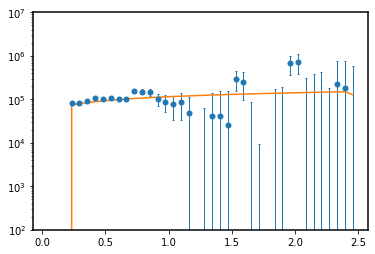

In [53]:
#plt.scatter(dmi.kpar_bins_obs.value, dmi.power_spectrum.value)
plt.errorbar(dmi.kpar_bins_obs.value, dmi.power_spectrum.value, yerr=np.sqrt(np.diag(dmi.covariance.value)), lw=0, marker='o', ms=5, capsize=1, capthick=1, elinewidth=1, )
plt.plot(dmi.kpar_bins_obs.value, dmi.compute_model([2e5, 2.7], []).value)
plt.yscale('log')
plt.ylim(1e2, 1e7)

In [17]:
like = MarginalizedLinearPositiveSystematics(model=dmi)
likeg = Gaussian(model=dmi)

/home/steven/work/hera/pspec_likelihood/src/pspec_likelihood/likelihood.py:630: UserWarning: Your covariance matrix is not diagonal. The MarginalizedLinearPositiveSystematics class requires diagonal covariance. Forcing it...
  warnings.warn(


In [18]:
print(like.loglike([1e5, 2.0], []), like.loglike([2e5, 2.7], []), like.loglike([1e2, 2.0], []), like.loglike([1e1, 2.0], []))

-30.13411209137063 -43.582564747826964 -17.982884633792303 -17.97448754522106


/home/steven/work/hera/pspec_likelihood/src/pspec_likelihood/likelihood.py:650: UserWarning: Warning: Ignoring data in positions (array([0, 1, 2]),) as the variance is zero
  warnings.warn(


In [21]:
print(likeg.loglike([1e5, 2.0], []), likeg.loglike([2e5, 2.7], []), likeg.loglike([1e2, 2.0], []), likeg.loglike([1e1, 2.0], []))

-5712.495709036636 -522.4063893413246 -8408.659560220136 -8411.353763393483


/home/steven/work/hera/pspec_likelihood/src/pspec_likelihood/likelihood.py:585: UserWarning: Warning: Ignoring data in positions (array([0, 1, 2]),) as the variance is zero
  warnings.warn(


In [22]:
amp = np.logspace(3, 7, 100)

likes = np.zeros(amp.shape)
likes_g = np.zeros(amp.shape)

for i, a in enumerate(amp):
    likes[i] = like.loglike([a, 2.7], [])
    likes_g[i] = likeg.loglike([a, 2.7], [])
    

/home/steven/work/hera/pspec_likelihood/src/pspec_likelihood/likelihood.py:670: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(erf(residuals_over_errors)),


In [23]:
indx = np.linspace(1, 3, 100)

likes_indx = np.zeros(indx.shape)
likes_g_indx = np.zeros(indx.shape)

for i, a in enumerate(indx):
    likes_indx[i] = like.loglike([2e5, a], [])
    likes_g_indx[i] = likeg.loglike([2e5, a], [])

/home/steven/work/hera/pspec_likelihood/src/pspec_likelihood/likelihood.py:670: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(erf(residuals_over_errors)),


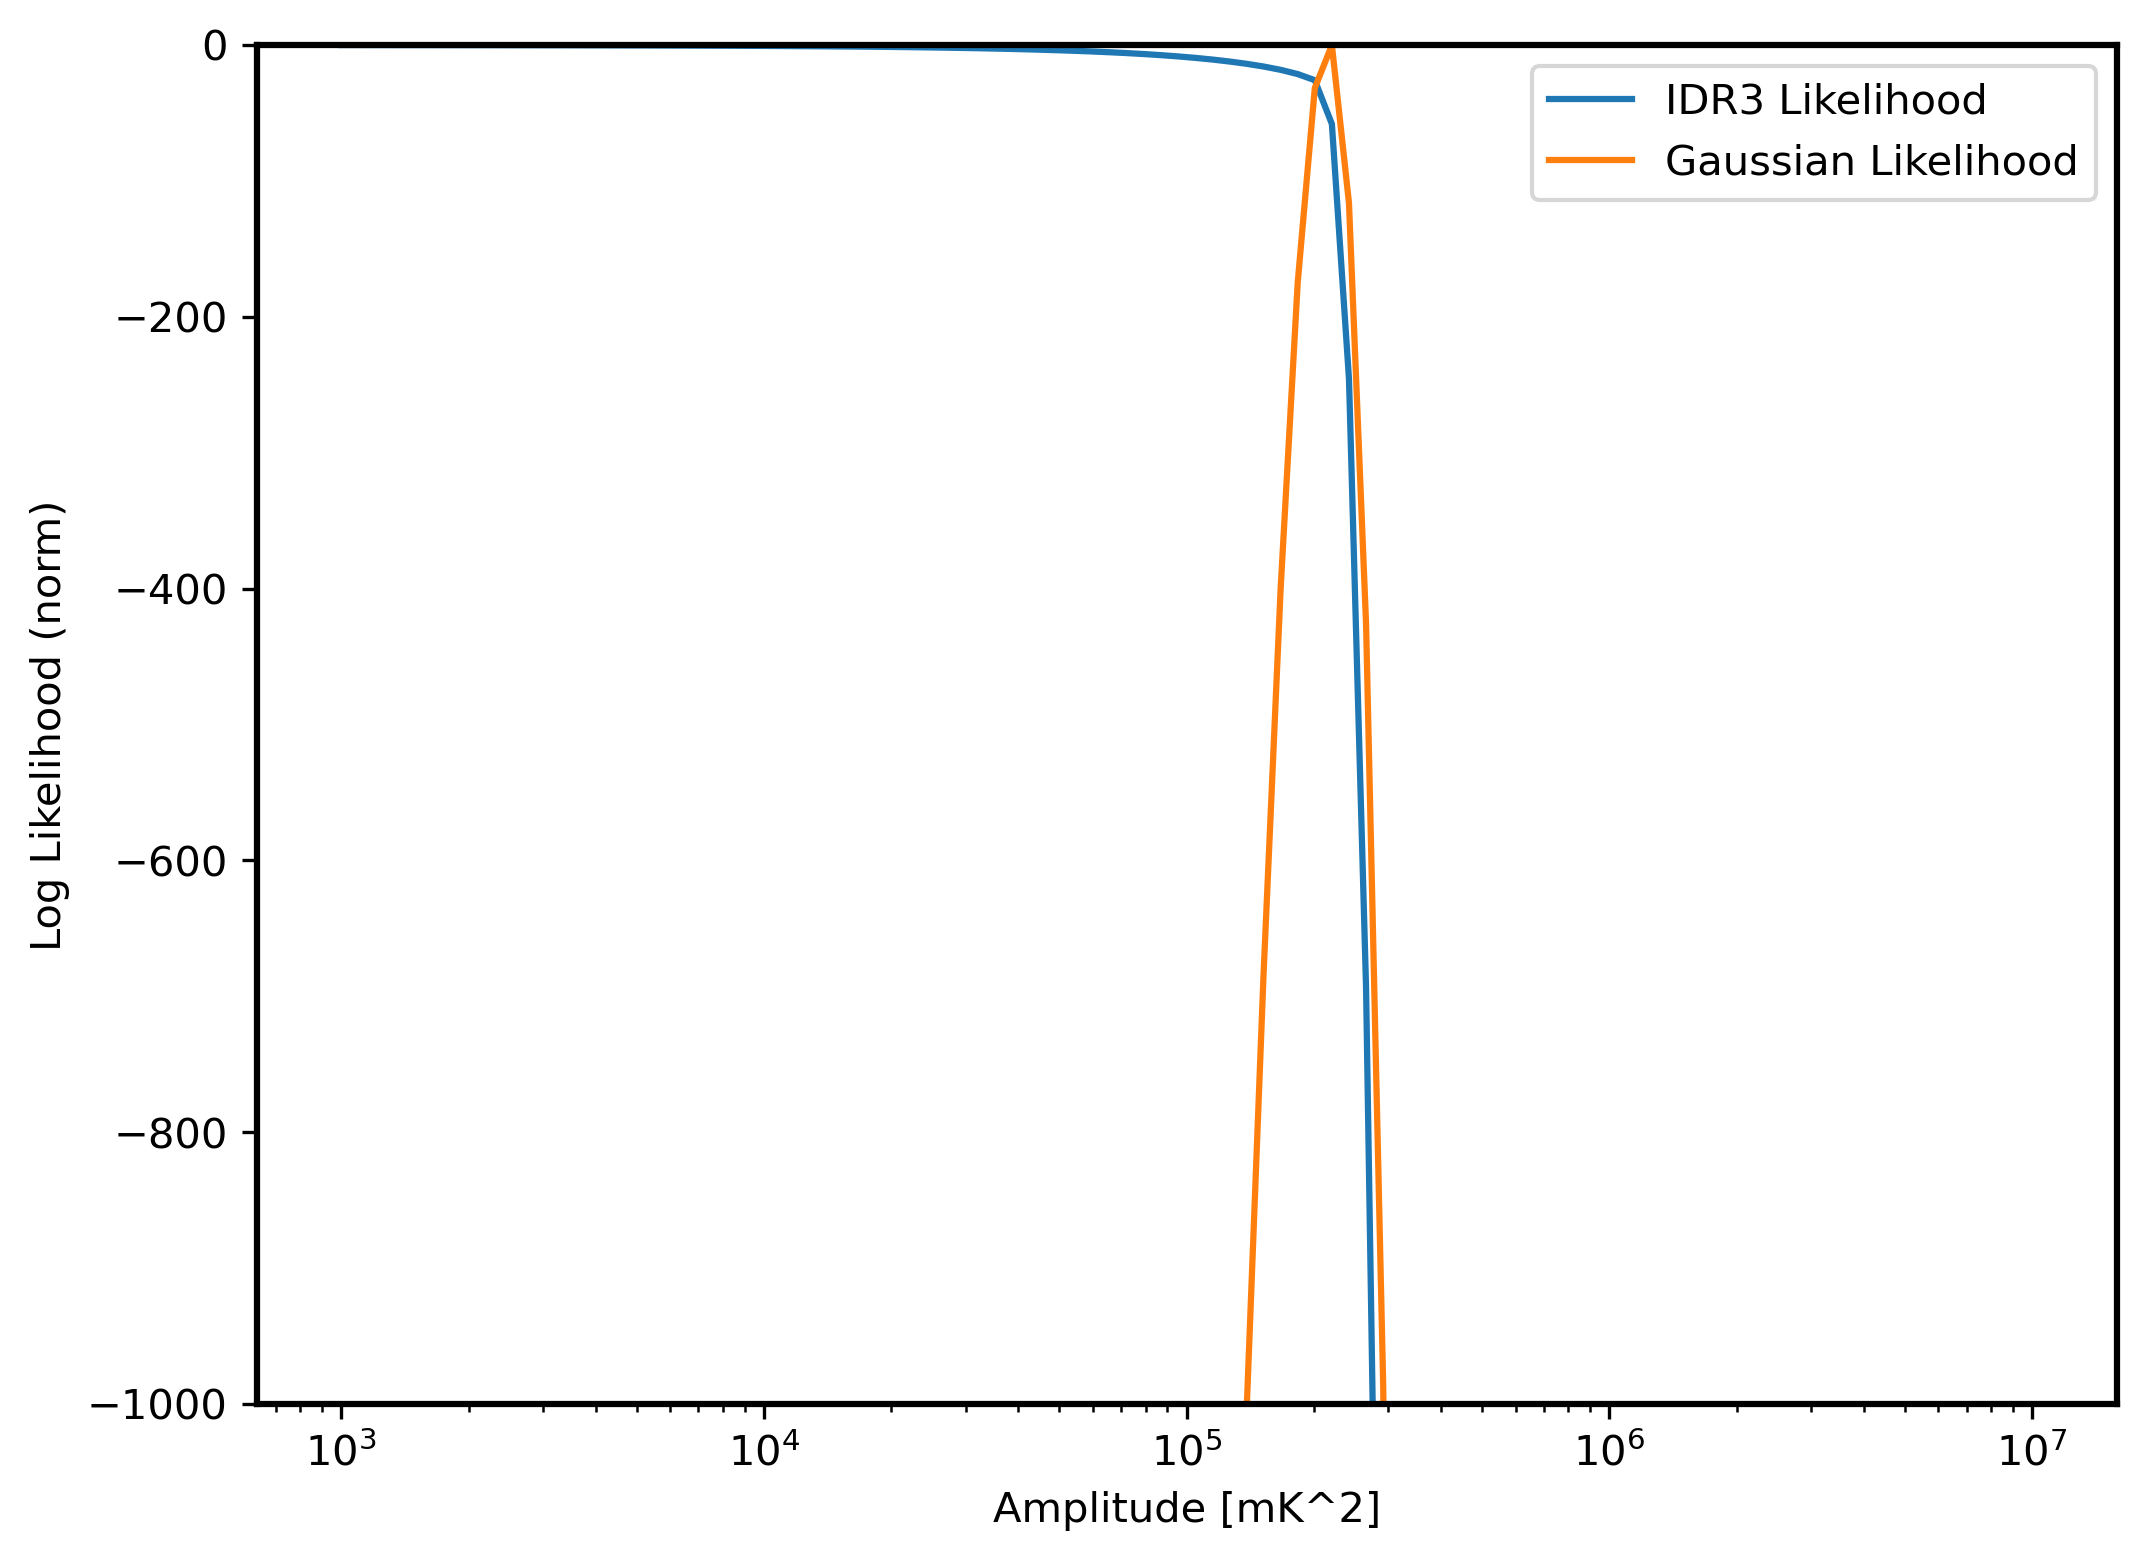

In [34]:
plt.figure(figsize=(8,6), dpi=300)
plt.plot(amp, likes - likes.max(), label='IDR3 Likelihood')
plt.plot(amp, likes_g - likes_g.max(), label='Gaussian Likelihood')
plt.xscale('log')
plt.ylim(-1000, 0)
plt.xlabel("Amplitude [mK^2]")
plt.ylabel("Log Likelihood (norm)")
plt.legend()

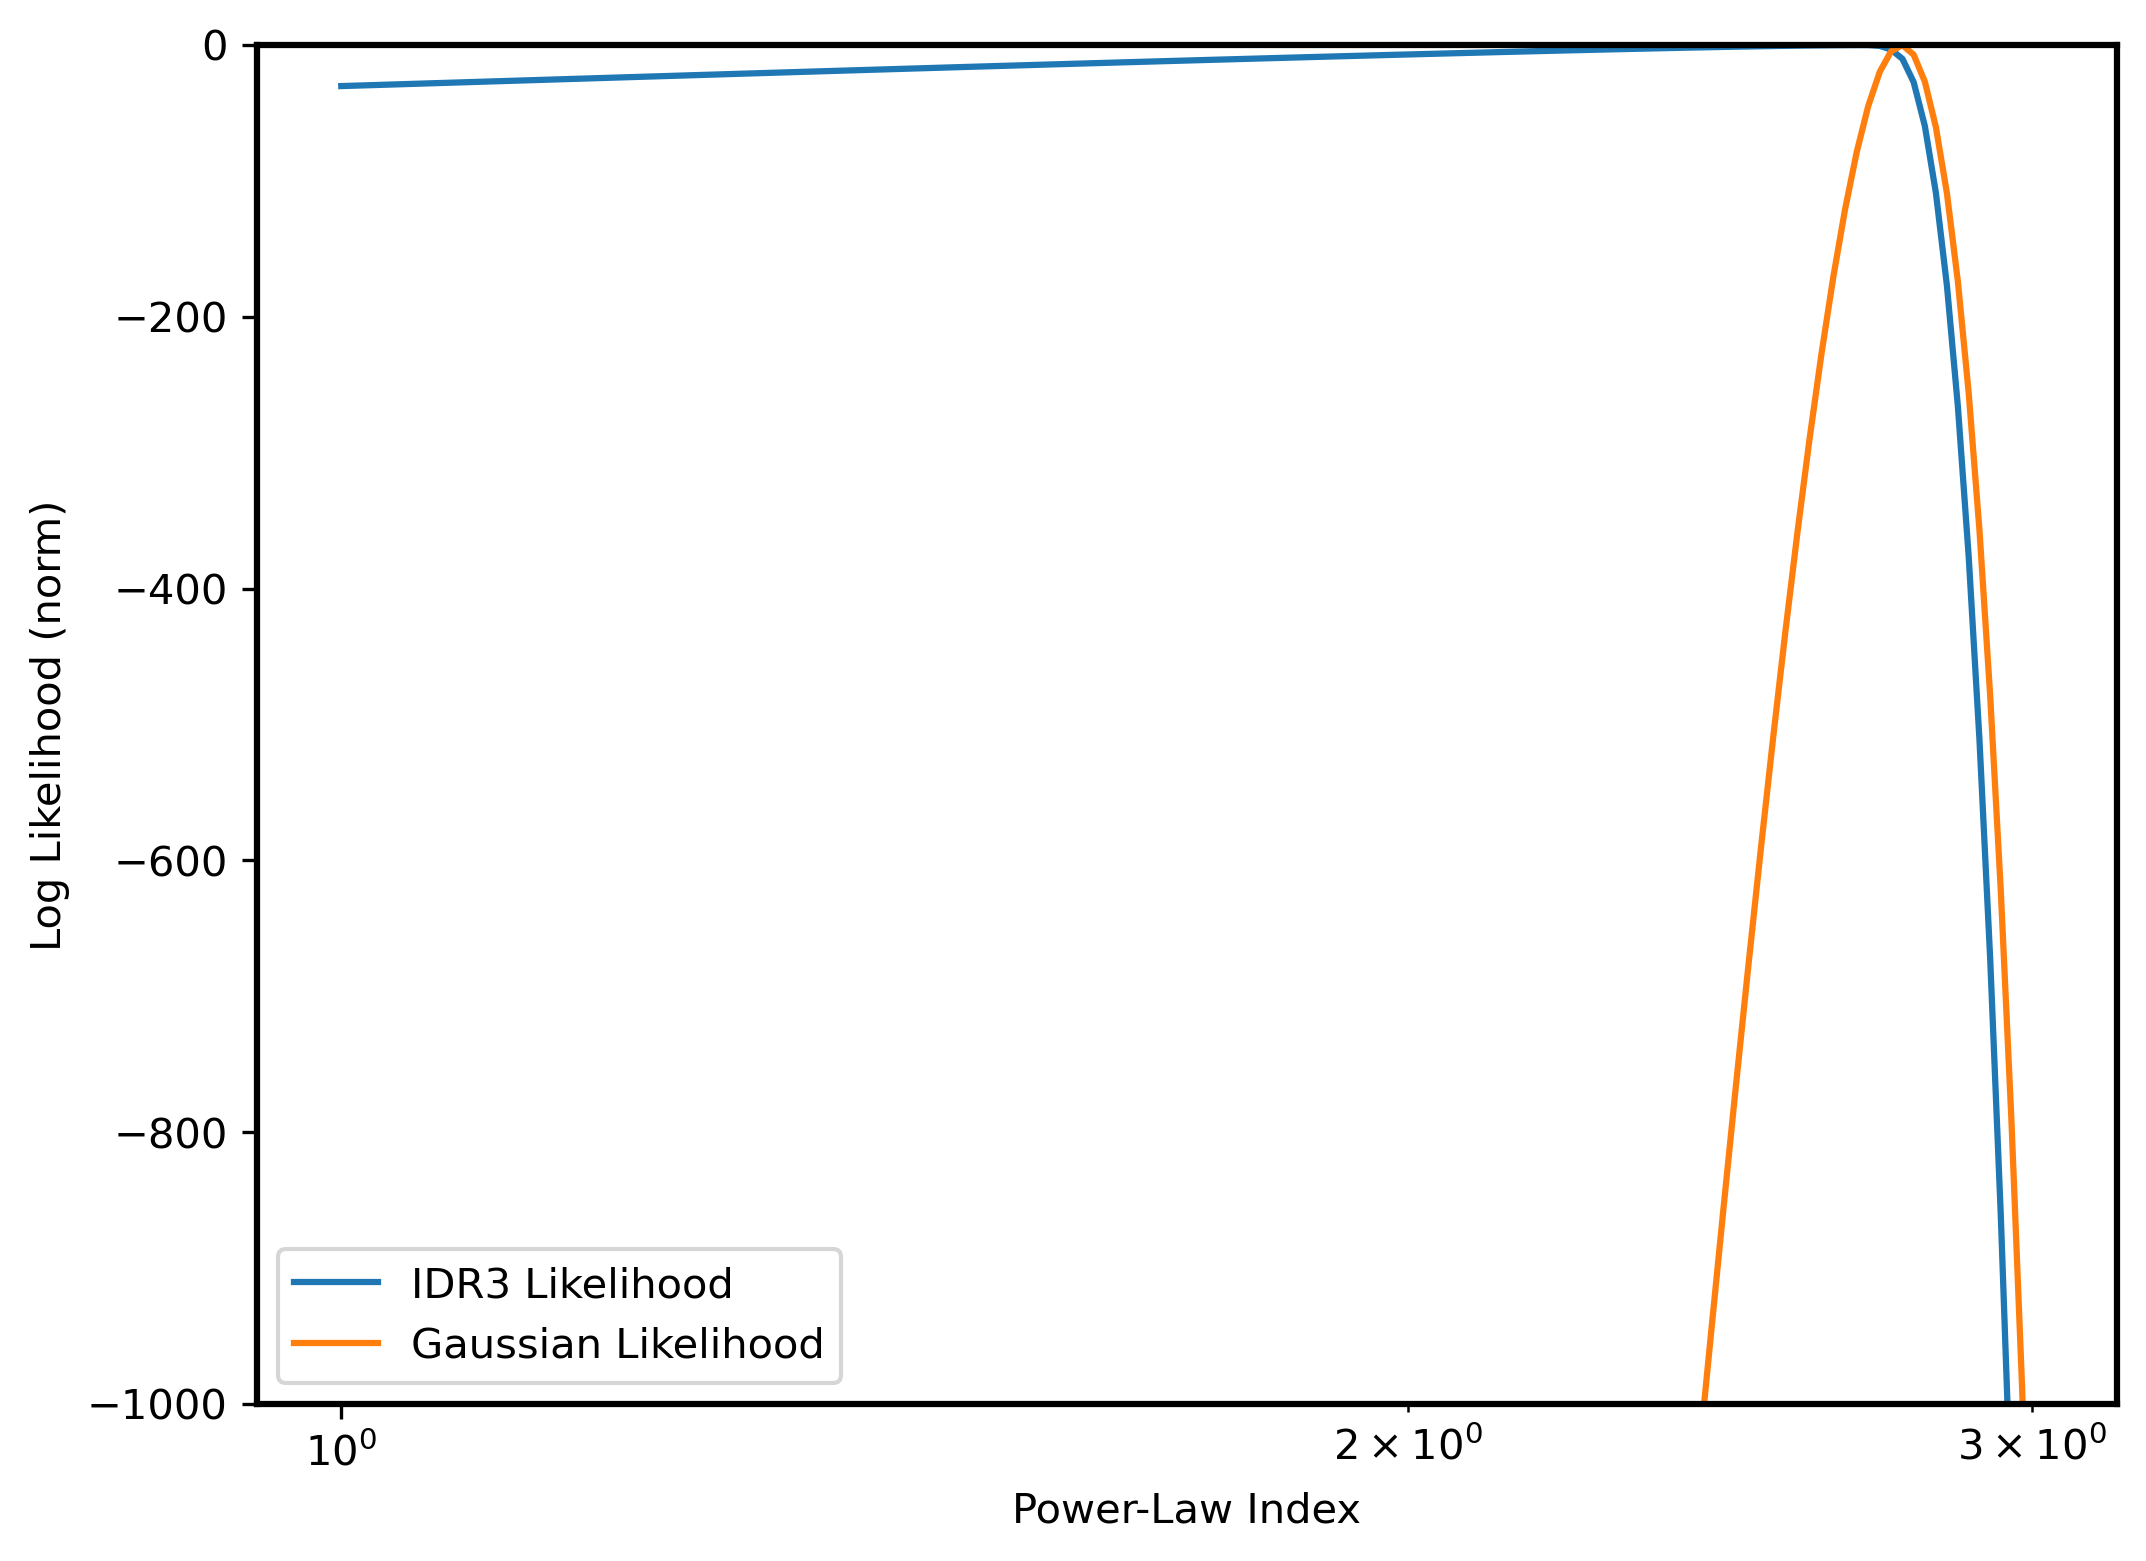

In [36]:
plt.figure(figsize=(8,6), dpi=300)
plt.plot(indx, likes_indx - likes_indx.max(), label='IDR3 Likelihood')
plt.plot(indx, likes_g_indx - likes_g_indx.max() , label='Gaussian Likelihood')
plt.xscale('log')
plt.ylim(-1000, 0)
plt.xlabel("Power-Law Index")
plt.ylabel("Log Likelihood (norm)")
plt.legend()